# Adaptive model detection (AMD) with neural network predictor

## Setup, imports, initialisation

### Importing

In [1]:
import numpy as np
import torch
from adaptive_model_detection import amd
from tqdm.notebook import tqdm

### Environments

Some sample environments are included in the `environments` folder. More environments and guidance on how to make your own that integrate with this code is included in [this repository](https://www.github.com/jupilogy/pomdp-tools "JupiLogy's POMDP tools").

In [2]:
from environments.pomdps import ENV8V1, ENV8V2

environment1 = ENV8V1
environment2 = ENV8V2

### Seed
Optionally, run with a seed of 0 to replicate figure 8 from the paper.

In [3]:
np.random.seed(0)

### Predictor

We use a vanilla neural network as our predictor. Of course, the architecture of this network can be changed. `hlen` is the length of history the network is fed at each timestep.

In [4]:
from agents.nn import vanilla_nn

hlen = 10
nn1 = vanilla_nn(in_size=hlen*2)
nn2 = vanilla_nn(in_size=hlen*2)

### AMD trackers

`hlen` for AMD should be quite long for an accurate p-value. A shorter p-value means the agent detects changes faster. In general, a more complex environment should be given a longer `hlen`.

In [5]:
amd1 = amd([[0.5, 0.5]], 1, 2, h_len=100)
amd2 = amd([[0.5, 0.5]], 1, 2, h_len=100)

### PSR for error reference

In order to determine the accuracy of the agent, we compare its prediction at each timestep against an accurate PSR. This is **not** used for the loss (since knowing the accurate prediction defeats the point of making an agent learn the accurate prediction).

In [6]:
from environments.transforms import pomdp_to_psr
Qr1, Ur1, Mr1 = pomdp_to_psr(environment1)
Sr1 = np.array([np.transpose(np.mean(Ur1, axis=0))])

Qr2, Ur2, Mr2 = pomdp_to_psr(environment2)
Sr2 = np.array([np.transpose(np.mean(Ur2, axis=0))])

def get_error(Sr, Mr, Qr, y_pred, a, o, dtype=torch.float):
    ao_r = Mr[int(a)][int(o)][0]
    new_r = np.zeros(Sr.shape[1])
    for ind in range(len(Qr)):
        aot_r = Mr[int(a)][int(o)][ind]
        if ao_r @ Sr[-1] < 1e-5:
            # Need to reset somehow if environment is switched
            new_r[ind] = 1e-2
        else:
            new_r[ind] = (aot_r @ Sr[-1]) / (ao_r @ Sr[-1])
    Sr = np.append(Sr, np.nan_to_num([new_r]), axis=0)
    err = 0
    next_r = torch.tensor([0, 0], dtype=dtype)
    for obs in range(2):
        next_r[obs] = Sr[-1] @ Mr[0][obs][0]
        err += (next_r[obs] - y_pred[obs]) ** 2
    return err/2, Sr


### Data generation

Generating data which switches between the environments.

In [7]:
from environments.datagen import random_traverse

data = np.append(
    random_traverse(10000, environment1),
    np.append(
        random_traverse(10000, environment2),
        np.append(
            random_traverse(5000, environment1),
            np.append(
                random_traverse(5000, environment2),
                np.append(
                    random_traverse(5000, environment1),
                    random_traverse(5000, environment2),
                    axis=0),
                axis=0),
            axis=0),
        axis=0),
    axis=0)

### Results storage

We will store the error of the agents and their p-values over time in these arrays.

In [8]:
error_array1 = []
error_array2 = []
pvals1 = []
pvals2 = []

## Training

### Which agent is trained?

If the agent is not given a certain amount of training in each environment, it will not learn the environment well enough for AMD to accurately predict if the predictions are accurate. Therefore, for the first 10000 timesteps in each environment, the trained agent is manually selected.

After this "supervised" phase, the agent with the highest p-value is trained. If both p-values are below 5%, neither agent is trained.

### What is used for the neural network loss?

The next observation provided by the environment is used for the loss. Note that this is **not** the same as the accurate prediction provided by the PSR.

In [10]:
for i in tqdm(range(data.shape[0] - hlen)):
    # Get next prediction from nn1 and nn2
    s1 = nn1.step(data[i: i+hlen].flatten())
    s2 = nn2.step(data[i: i+hlen].flatten())

    # Step AMD trackers at each timestep
    amd1.step(np.array([s1.detach().numpy()]), *data[i + hlen-1])
    amd2.step(np.array([s2.detach().numpy()]), *data[i + hlen-1])

    if i + hlen < 10000:
        # For first 10000 timesteps, only train nn1
        err2, Sr2 = get_error(Sr1, Mr1, Qr1, s2, *data[i + hlen-1])
        err1, Sr1 = get_error(Sr1, Mr1, Qr1, s1, *data[i + hlen-1])
        nn1.backward(*data[i + hlen])
    elif i + hlen < 20000:
        # For second 10000 timesteps, only train nn2
        err1, Sr1 = get_error(Sr2, Mr2, Qr2, s1, *data[i + hlen-1])
        err2, Sr2 = get_error(Sr2, Mr2, Qr2, s2, *data[i + hlen-1])
        nn2.backward(*data[i + hlen])

    # From then on, train the network with the highest p-value, unless both p-values are low
    elif i + hlen < 25000 or 30000 < i + hlen < 35000:
        err2, Sr2 = get_error(Sr1, Mr1, Qr1, s2, *data[i + hlen-1])
        err1, Sr1 = get_error(Sr1, Mr1, Qr1, s1, *data[i + hlen-1])
        if amd1.p_val > amd2.p_val and amd1.p_val > 0.05:
            nn1.backward(*data[i + hlen])
        elif amd2.p_val > 0.05:
            nn2.backward(*data[i + hlen])
    else:
        err1, Sr1 = get_error(Sr2, Mr2, Qr2, s1, *data[i + hlen-1])
        err2, Sr2 = get_error(Sr2, Mr2, Qr2, s2, *data[i + hlen-1])
        if amd1.p_val > amd2.p_val and amd1.p_val > 0.05:
            nn1.backward(*data[i + hlen])
        elif amd2.p_val > 0.05:
            nn2.backward(*data[i + hlen])

    # Add error and p-values to storage arrays
    error_array1.append(err1)
    error_array2.append(err2)
    pvals1.append(amd1.p_val)
    pvals2.append(amd2.p_val)

## Data output

In [11]:
import matplotlib.pyplot as plt

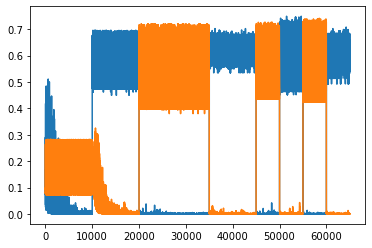

In [12]:
plt.plot(error_array1)
plt.plot(error_array2)
plt.show()

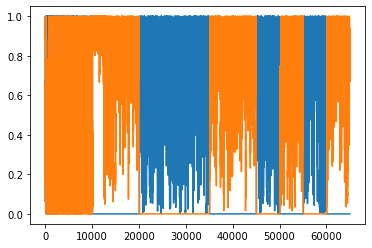

In [13]:
plt.plot(pvals1)
plt.plot(pvals2)
plt.show()